# Network measurement laboratory - report 4


## Introduction

This assignment aims to analyze the output of *Tstat*, a free open-source passive network monitoring tool, while it was capturing traffic in the Politecnico's internal network in 2015.    
The first Task, common to all working groups, targets the analysis of TCP connections in a general way while the second Task is group specific and aims to a deeper investigation of a given webservice. For us, the chosen webservice is **Spotify**.

## Task 1



### 1.1

For this exercise we needed to compute the number of *local* (who's IP address belongs to the network) clients' TCP connections directed towards all the unique services matching the string _*facebbok.com_ and to plot them in a barplot. Moreover, we were asked to plot them in decreasing order and only the top-20 of them. The match has been done considering first what reported in column 127 (namely *fqdn:127*), then, in the case of no match, column 131 (namely *http_hostname:131*), 116 (namely *c_tls_SNI:116*) and 117 (namely *s_tls_SCN:117*) in this sequential order.

In order to fulfill the requirements, some lines of code must be added. First, the necessary libraries must be imported (*pandas*, *matplotlib* and *numpy*) and we also defined two methods which had to be used within *pandas.DataFrame.apply()* method and which are very useful to obtain the wanted results.

In [19]:
# Import useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Define useful methods to be used within pandas.DataFrame.apply() method
def find_match(row):
    
    string = 'facebook.com'
    
    if string in row['fqdn:127']:
        return row['fqdn:127']
    
    elif string in row['http_hostname:131']:
        return row['http_hostname:131']
    
    elif string in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    
    else :
        return row['s_tls_SCN:117']
    

def find_match_regex(row):
    
    string = 'facebook'
    
    if string in row['fqdn:127']:
        return row['fqdn:127']
    
    elif string in row['http_hostname:131']:
        return row['http_hostname:131']
    
    elif string in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    
    else :
        return row['s_tls_SCN:117']

Once the libraries are correctly imported and the methods successfully defined, we can proceed to import the file. Due to its huge dimensions, it is unfeasible to load it at once. Therefore, we proceed analyzing it in chunks of 100000 rows.

In [3]:
# Read file CSV
# dataf = pd.read_csv('log_tcp_complete.xz', sep=' ', nrows=100000)    # used for preliminary results
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

# Filter DataFrame for "/*facebook.com"
fb_string = '/*facebook.com'        # define string to be matched
fb_dataf = pd.DataFrame()           # define new dataframe to be used for evaluations
tmp = pd.DataFrame()                # define support dataframe

for chunk in df_iter:
    tmp = chunk[(chunk['c_isint:38'] == 1) &
                ((chunk['fqdn:127'].str.contains(fb_string)) |
                 (chunk['http_hostname:131'].str.contains(fb_string)) |
                 (chunk['c_tls_SNI:116'].str.contains(fb_string)) |
                 (chunk['s_tls_SCN:117'].str.contains(fb_string))
               )]
    fb_dataf = pd.concat([fb_dataf, tmp])
    
# print(fb_dataf)

For every chunk of read file we filter it according to the previously mentioned parameters. Thanks to `chunk['c_isint:38'] == 1` in fact, we select only internal clients in the network and with the subsequent lines of code we search for those connections which have a match for the desired string in one of the 4 columns of interest.
Then, we apply to each row of the filtered dataframe (`DataFrame.apply()`) the previously defined method `find_match()`, which returns a string of services names including the string _*facebbok.com_. This is useful because we then can add this list of names to our dataframe, in order to simplify the analysis and the plots.

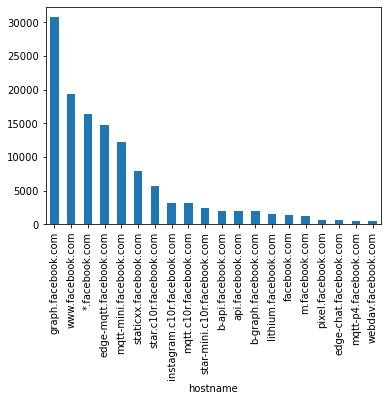

In [4]:
new_col = fb_dataf.apply(find_match, axis=1)
# new_col
fb_dataf.insert(len(fb_dataf.columns), 'hostname', new_col)
# fb_dataf 

# Group and plot
fb_service = fb_dataf.groupby(['hostname']).size()
# fb_service
barplot = fb_service.sort_values(ascending=False).head(20).plot(kind='bar')

Once added the new column to the dataframe, we can then use the method `DataFrame.groupby()` to group them according to some parameter. Since we are asked to find the number of distinct services to which internal hosts are connected to, we group them in accordance with the newly created column *hostname*. In this case we want to know the total number of connections towards each service, therefore we exploit the method `size()` to retrieve it. Afterwards, we plot the 20 most used services in descending order using bars.

Observing the plot, the service with the most TCP connections is *graph.facebook.com*. By a deeper investigation on what the domain represented it resulted to be:
>The Graph API is the primary way to get data into and out of the Facebook platform. It's an HTTP-based API that apps can use to programmatically query data, post new stories, manage ads, upload photos, and perform a wide variety of other tasks. - *https://developers.facebook.com/docs/graph-api/overview*

Consequently, the reason why it has the most connections becomes clear. Indeed, it has more than 10000 more connections than the main service *www.facebook.com*.    
Among the other services depicted in the plot, it is interesting the presence in the first positions of *edge-mqtt.facebook.com*, *mqtt-mini.facebook.com*, *staticxx.facebook.com* and *star.c10r.facebook.com* which are Facebook's trackers: the sum of all of them reaches more than 40000 connections. Moreover, even after these ones, there are others reported in the plot, meaning that a great part of the traffic between clients and Facebook's services implies a lot of tracking, which may not be something wanted nor safe for the users. Then, we can also observe some traffic to some *Instagram* service (through Facebook domain) and some other Facebook's APIs services.

Afterwards, we proceed to test the regex concept making the experiment again, but using _\*facebook\*_ as string for the search and the method `find_match_regex()` defined previously to obtain more matches in the dataframe.

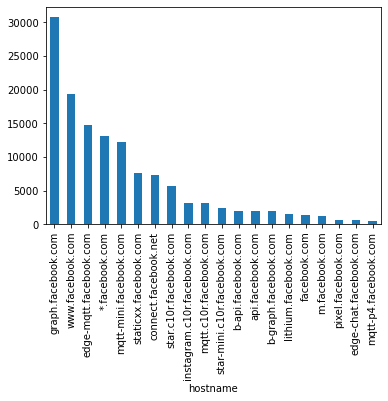

In [4]:
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

# Filter DataFrame for "/*facebook*"
fb_string_reg = '/*facebook*'
fb_dataf_reg = pd.DataFrame()           # define new dataframe to be used for evaluations
tmp = pd.DataFrame()                    # define support dataframe

for chunk in df_iter:
    tmp = chunk[(chunk['c_isint:38'] == 1) &
               ((chunk['fqdn:127'].str.contains(fb_string_reg)) |
                (chunk['http_hostname:131'].str.contains(fb_string_reg)) |
                (chunk['c_tls_SNI:116'].str.contains(fb_string_reg)) |
                (chunk['s_tls_SCN:117'].str.contains(fb_string_reg))
               )]
    fb_dataf_reg = pd.concat([fb_dataf_reg, tmp])
    
# print(fb_dataf)

new_col = fb_dataf_reg.apply(find_match_regex, axis=1)
# new_col
fb_dataf_reg.insert(len(fb_dataf_reg.columns), 'hostname', new_col)
# fb_dataf_reg 

# Group and plot
fb_service_reg = fb_dataf_reg.groupby(['hostname']).size()
# fb_service
barplot_reg = fb_service_reg.sort_values(ascending=False).head(20).plot(kind='bar')

With respect to the previous result there are not many changes. The most significant ones are the presence of the service *connect.facebook.net* which was previously excluded due to its domain *.net* and the exchange in position between the services *edge-mqtt.facebook.com* and _\*.facebook.com_. While the first difference is indeed significant because it shows almost 10000 further TCP connections that were previously filtered out, the second difference is marginal. This suggests us that Facebook's services are mainly hosteb by ".com" domains.   
Therefore, we can deduce that the way we filter the data is ideed a crucial point: we do not want to exclude significant numbers of connections being too strict with search parameters but also being too loose we risk to have much more useless or un-needed data.

### 1.2

For this exercise we have to find the top-15 most used services without any filter on local client nor service and plot them using again a descending order bar plot

In order to fulfill the requirements, we defined another method, namely `find_TCP()`, which allows us to get from each line of the dataset the service it refers to by scanning the previously used 4 colums, avoiding counting missing elements.
We then apply this method to the whole dataframe, grouoping results by service and plot the obtained result.

In [2]:
# 15 most used TCP services in general

# Define useful method to be used within pandas.DataFrame.apply() method
def find_TCP(row):
    
    string = '-'
    
    if string not in row['fqdn:127']:
        return row['fqdn:127']
    
    elif string not in row['http_hostname:131']:
        return row['http_hostname:131']
    
    elif string not in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    
    elif string not in row['s_tls_SCN:117']:
        return row['s_tls_SCN:117']

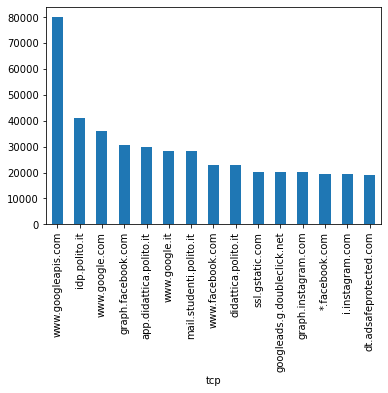

In [3]:
# Read file CSV
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)
    
top15 = pd.DataFrame()
tmp = pd.DataFrame()

for chunk in df_iter:
    tmp = chunk.apply(find_TCP, axis=1)
    top15 = pd.concat([top15, tmp])
    
# print(top15)
    
top15.columns = ['tcp']
top15_all = top15.groupby(['tcp']).size()
barplot = top15_all.sort_values(ascending=False).head(15).plot(kind='bar')

The result depicted in the picture is not surprising: 
- the most number of connections are towards Google (*www.googleapis.com*, *www.google.com*, *www.google.it*) and some of its sub-services
- there are plenty of connection to the Politecnico's intranet as well (*app, mail, didattica* and *idp*)
- the other most numerous TCP flows are towards Facebook services (such as the previously mentioned *graph.facebook*, *graph.instagram* besides *facebook.com*)

We can also notice that is present the service named *dt.ad**safeprotected**.com*: is a dangerous popup page generated by potentially unwanted program. Thus, it is somehow concerning that a potential dangerous service is in the top-15 services of the Politecnico's network and furthermore that has a name suggesting safety and protection.

The previous analysis was done considering all kind of TCP connections (HTTP, HTTPS, P2P, IMAP4, ecc). If instead the same experiment is repeated considering only the ones exploiting HTTPS we can see that many services decrease their size. In fact, some services like *www.google.com* and *graph.facebook.com* lost around 10000 connections which is already a consistent number considering the network size.     
Moreover, we can observe that the Politecnico's intranet services remained unchanged, gaining also some positions. This is an indication that who managed our network in 2015 was already providing a good service to students and personnel and was privacy-conscious.      
In the end we can also notice that many services present in the previous graph are now absent and are mainly replaced by some other Google sub-services and Outlook login page (*login.live.com*).

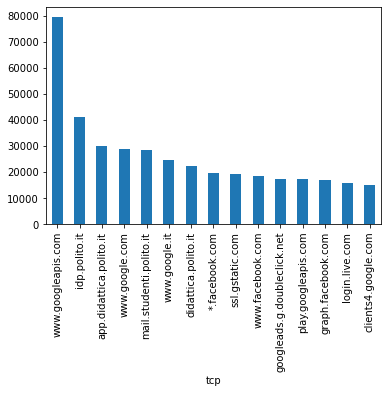

In [4]:
# 15 most used TCP services in general using HTTPS (TLS)

# Read file CSV
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)
    
top15_tls = pd.DataFrame()
tmp = pd.DataFrame()

for chunk in df_iter:
    # Filter DataFrame for TLS
    tmp = chunk[(chunk['con_t:42'] == 8192)].apply(find_TCP, axis=1)
    top15_tls = pd.concat([top15_tls, tmp])
    
# print(top15_tls)
    
top15_tls.columns = ['tcp']
top15_https = top15_tls.groupby(['tcp']).size()
barplot = top15_https.sort_values(ascending=False).head(15).plot(kind='bar')

### 1.3
We are now asked to analyze the fraction of connections for different "connection type" considering again the whole dataframe without any filtering applied.

We iterate over the whole file in order to get all the useful data, which we save in a list. At the end of the reading, all the values stored in the list are summed together and normalized (ignorig NaN values) before being plotted in a barplot.

In [25]:
# Count the fraction of connections for different “connection type”

# Read file CSV
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

connections = []

for chunk in df_iter:
    connections.append(chunk.groupby(['con_t:42']).size())
    
# print(connections)

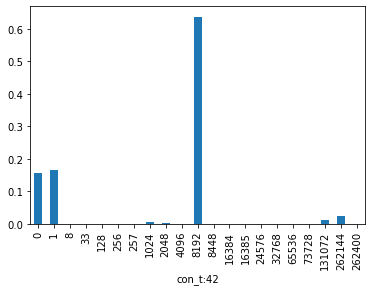

In [60]:
# Normalize and plot
all_connections = sum(connections)
all_connections = all_connections/np.nansum(all_connections)
# print(all_connections)
barplot = all_connections.plot(kind='bar')

From the graph we can observe that more than 60% of the observed traffic use HTTPS (column 8192 in the graph). This is a good indicator that the most data traffic in the network has at least a level of protection assured by the protocol. However, still 16% of traffic is using the less secure HTTP version (column 1 in the graph).   
It can also be oserved that more than 15% of the traffic uses an unknown protocol (column 0) and all the remaining traffic combined has negligible impact: 5% of the whole traffic. Among that 5% the main used protocols are the ones corresponding to the column 262144 with 2% of traffic, *Bittorrent MSE/PE protocol* (column 131072) with 1% and *SMTP protocol* (column 1024) with 0.05%.

Since the connection type is a bitmask, it's possible to have combinated values, thus probably the 262144 column is the combination of *Bittorrent MSE/PE protocol and Bittorrent MSE/PE protocol* (131072 + 131072 = 262144). The same reasoning can be applyed to other values present in the graph like 257 (HTML and P2P) or 8448 (HTTPS and P2P).

### 1.4
We now try to evaluate the fraction of HTTP, HTTPS and all the others protocols flows and their behavior in time.

As just seen in the previous graph, we expect to have a big difference between HTTPS and HTTP since the first should be around 60% all the time and the second one around 15%. We also expect the sum of all the other protocols to be very low, while the unknown ones to behave similarly to HTTP since previously we observed lower but similar values.

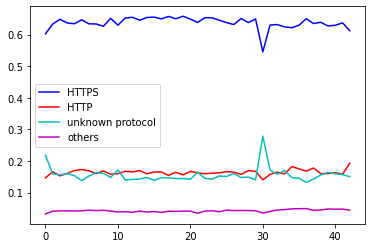

In [73]:
# Count the fraction of protocols flows for each group

# Read file CSV
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

rates_HTTP = []
rates_HTTPS = []
rates_unknown = []
rates_other = []
for chunk in df_iter:
    rates_HTTP.append(chunk[(chunk['con_t:42'] == 1)].shape[0]/chunk.shape[0])
    rates_HTTPS.append(chunk[(chunk['con_t:42'] == 8192)].shape[0]/chunk.shape[0])
    rates_unknown.append(chunk[(chunk['con_t:42'] == 0)].shape[0]/chunk.shape[0])
    rates_other.append(chunk[(chunk['con_t:42'] != 8192) & (chunk['con_t:42'] != 1) & (chunk['con_t:42'] != 0)].shape[0]/chunk.shape[0])
    
plt.plot(rates_HTTPS, 'b', label='HTTPS')
plt.plot(rates_HTTP, 'r', label='HTTP')
plt.plot(rates_unknown, 'c', label='unknown protocol')
plt.plot(rates_other, 'm', label='others')
plt.legend()
plt.show()

The plot reflects indeed our preliminary expectations: HTTPS outperforms with respect to all other protocols at around 60%, HTTP and unknown protocols behave similarly and finally all the remaining procols stand at 5%. Observing the graph we can also apppreciate that the overall behavior in time of all the lines is somehow constant.    
The only discontinuity appears with the 30th read chunk: there is a significant decrease of the HTTPS traffic, a small decrease in HTTP and at the same time an increase of around 10% for the traffic of the unknown protocols. Curiously, this sudden change becomes negligible already in the very next chunk of data. Probably some sudden event happened in the network that needed a peculiar connection protocol, not identified by *Tstat*.

## Task 2

For this task we were asked to perform more deep and accurate analysis of the file, filtering it according to a web service of our choice, by showing statistics about their usage and the sub-services it uses.     
Our choice was to concentrate on **Spotify**.

To meet the requirements for the whole task a filtering on the full dataset is essential. The first, more logial and immediate choice was to filter according to the string _\*spotify\*_. In such a way we should be able to obtain all the direct Spotify sub-services. Then, a more deep search on the internet suggested some others domains like *open.scdn.co*, *geo3.ggpht.com*, *redirector.gvt1.com* and some others _/*.scdn.co_ domain names. Applying a filter also for those domains resulted in complicating all evaluations. Because of the growth of Spotify from 2015 to nowadays (140 million subscribers more in 2021 with respect to 2015) in fact, many domain names have been changed or added.     
Therefore, we choose to limit ourselves with the main services and sub-services directly linkable to Spotify.

Thus, we defined a new method, namely `find_spotify(row)`, to be used within `pandas.DataFrame.apply()` able to filter out all the rows of our interest and imported a new library: *seaborn*.     
Once determined the filter to be applied, we proceeded to create a local dataframe containing only the rows of our interest. Moreover, we decided to adopt the same strategy used for Task 1.1, i.e. we added to the local dataframe a new column called *hostname* which contains the result of the filtering process. This is extremely helpful when some manipulation of the dataframe is needed according to the services names.

In [1]:
# For convenience while doing task we import again all needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

In [2]:
# Define useful method to be used within pandas.DataFrame.apply() method
def find_spotify(row):
    
    string = 'spotify'
    
    if string in row['fqdn:127']:
        return row['fqdn:127']
    
    elif string in row['http_hostname:131']:
        return row['http_hostname:131']
    
    elif string in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    
    else :
        return row['s_tls_SCN:117']
    
# Read file CSV
# dataf = pd.read_csv('log_tcp_complete.xz', sep=' ', nrows=100000)    # used for preliminary results
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

# Filter DataFrame for "/*spotify*"
sp_string = '/*spotify*'            # define string to be matched
sp_dataf = pd.DataFrame()           # define new dataframe to be used for evaluations
tmp = pd.DataFrame()                # define support dataframe

for chunk in df_iter:
    tmp = chunk[(chunk['c_isint:38'] == 1) &
                ((chunk['fqdn:127'].str.contains(sp_string)) |
                 (chunk['http_hostname:131'].str.contains(sp_string)) |
                 (chunk['c_tls_SNI:116'].str.contains(sp_string)) |
                 (chunk['s_tls_SCN:117'].str.contains(sp_string))
               )]
    sp_dataf = pd.concat([sp_dataf, tmp])

new_col = sp_dataf.apply(find_spotify, axis=1)
# new_col
sp_dataf.insert(len(sp_dataf.columns), 'hostname', new_col) 

sp_dataf = sp_dataf.rename(columns={'#15#c_ip:1':'client_IP', 's_ip:15':'server_IP'})

### 2.1

The first result we have to obtain is to identify which are the protocols used by Spotify to communicate with clients.

In order to do so, it is sufficient to apply a further filter on the dataframe we extracted from the whole file. We can search for different values in the column named `'con_t:42'` which collects the data we are searching for.   
Then, we simply plot them using a descending order barplot.

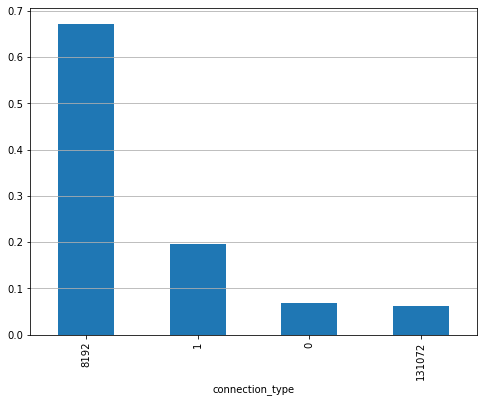

In [26]:
# POINT 5
# group by connection type
protocols = sp_dataf.rename(columns={'con_t:42':'connection_type'})\
                    .groupby(['connection_type']).size()   

# normalize values
all_protocols = protocols.sum()
protocols = protocols/all_protocols
# print(protocols)

# plot using barplot
a = protocols.sort_values(ascending=False).plot(kind='bar', figsize=(8,6))
a.grid(axis='y')

Interestingly, Spotify in 2015 appeared to be using only 4 different protocols for its main services. For the 67% it was using HTTPS and only about 20% of the connections were exploiting HTTP. It is also unusual to see that 6% of the whole Spotify traffic adopted the *Bittorrent MSE/PE protocol* (131072 column) while for nearly 7% of connections it was not possible to identify the protocol used.

### 2.2

Subsequently, we were asked to plot the total number of connections per sub-service.

This assignement can be solved exploiting the previously created column *hostname* which collects sub-services names, grouping accordingly the dataframe.

How many different sub-services?  332


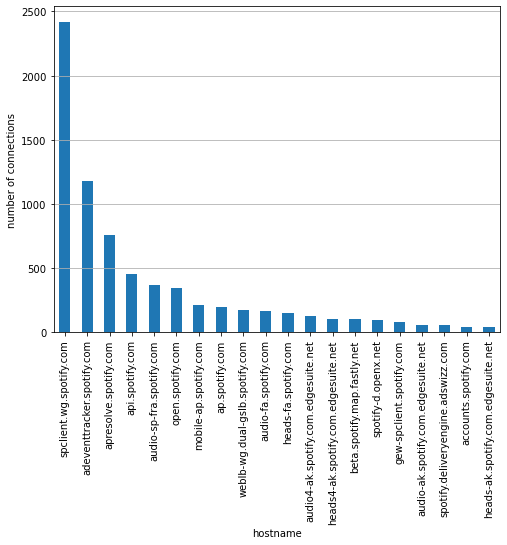

In [12]:
# POINT 6
# group and plot by hostname (sub-services)
sp_hostname_df = sp_dataf.groupby(['hostname']).size()
a = sp_hostname_df.sort_values(ascending=False).head(20)\
                  .plot(kind='bar', figsize=(8,6), ylabel='number of connections')
# print(sp_hostname_df.sort_values(ascending=False).head(20))
a.grid(axis='y')

print('How many different sub-services? ', sp_hostname_df.value_counts().sum())
# print('What is their name? ')
# services_names = []
# for name in sp_hostname_df.items():
#    services_names.append(name[0])
#    print(name[0])

We found 332 distinct sub-services linked to Spotify.  Anyhow, it seems that only the first 6 are significant in terms of number of connection. Indeed, while the service *spclient.wg.spotify.com* has almost 2500 connections the second  one, *adeventtracker.spotify.com*, has already more than 1200 less flows. Next, the gap between this last service and *apresolve.spotify.com*, which is the third more numerous, is around 400. Below that we are then considering values beneath 500 and after *open.spotify.com*, which is the 6th largest service, there are only values of connections that starting from around 200 are quickly reaching values below 100 connections per service.

Doing some researches we found that while it is not clear what is *spclient.wg.spotify.com*'s duty (with high probability is a client connections gateway), the 2 other most contacted domains are those which allow Spotify to place advertisment in their app or web service (*adeventtracker.spotify.com*) and to verify the subscribers status (*apresolve.spotify.com*). Below the first 3 services we can see the that there are the API service (*api.spotify.com*), the service allowing to actually listen to music (*audio-sp-fra.spotify.com*), the free-to-use web version of Spotify (*open.spotify.com*) and the app for smartphones (*mobile-ap.spotify.com* and *ap.spotify.com*). Further back we can find also other domains used for collecting analytics and used for advertisment purposes.

### 2.3

We now investigate which IP addresses of servers are used by Spotify.

To obtain the aimed output we filter the dataframe according to the column we renamed *server_IP*, extracting its size.

How many different IP addresses?  342


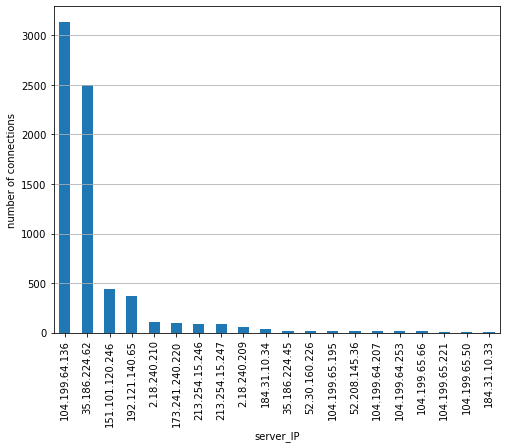

In [10]:
# POINT 7
# group and plot by server IP 
sp_hostname_df = sp_dataf.groupby(['server_IP']).size()
a = sp_hostname_df.sort_values(ascending=False).head(20).plot(kind='bar', figsize=(8,6), ylabel='number of connections')
a.grid(axis='y')

print('How many different IP addresses? ', sp_hostname_df.value_counts().sum())
# print('What is their name? ')
# services_names = []
# for name in sp_hostname_df.items():
#    services_names.append(name[0])
#    print(name[0])

From the plot we notice that more than 70% of the overall TCP flows are only towards two distinct IP addresses, namely 104.199.64.136 and 35.186.224.62, suggesting us that those are two big servers, probably hosting more than one service.    
While the overall number of used addresses is 342 the number of distinct sub-services is 332 meaning that each subservice uses more than one IP address.

### 2.4

Next, we have to analyze how are sub-services mapped to server IPs

To achieve the goal we group the dataframe first according to the *hostname* and then according to their *server_IP*, collecting all the unique values.

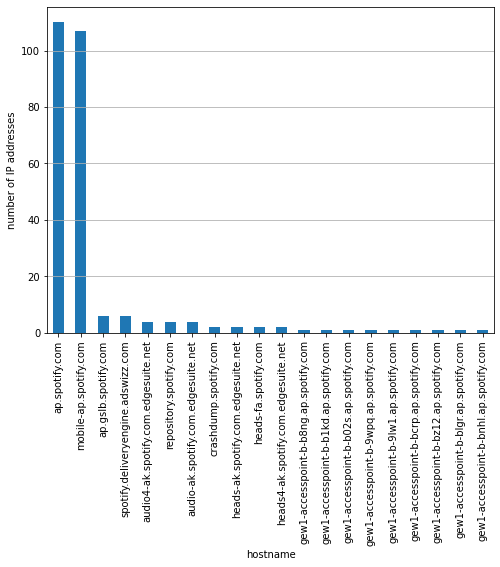

In [9]:
# POINT 8.1
# Plot the number of distinct server IPs for each subservice
a = sp_dataf.groupby(['hostname'])['server_IP'].nunique()\
            .sort_values(ascending=False).head(20).plot(kind='bar', figsize=(8,6), ylabel='number of IP addresses')
a.grid(axis='y')
# print(sp_dataf.groupby(['hostname'])['server_IP'].nunique().sort_values(ascending=False).head(20))

From the graph we can observe a particular result: the 63% of all the IP addresses used by all the sub-services are benefit of only two, namely *ap.spotify.com* and *mobile-ap.spotify.com*. Since those are the services allowing to access the mobile app and listening to music this result should not surprise.

We have yet to understand why there is more than one server IP address per sub-service and if they are all from the same network (for each service).      
Thanks to a deeper inspection of the IPs associated to each sub-service, we found that of the latter, the top two (*ap.spotify.com* and *mobile-ap.spotify.com*) have connections towards the subnets 104.199.64.0/24 and 104.199.65.0/24. By searching on the internet, it resulted that these two bunch of IP addresses are part of the bigger range of addresses 104.199.0.0/14. This specific range of IP addresses is owned by Google LLC, more in detail we discovered that those IPs should be assigned to servers located in Mountain View, California, USA. Since the two services are the ones allowing users to actually listen to music, we believe that Spotify is hosted in those Google owned servers.

This also answers to the first question: many clients may access the same server IP address but likely a single server IP cannot serve an infinite amount of users. Therefore some other addresses must be allocated in order to provide service to all users, satisfying their needs.     
The other sub-services having more than one assigned IP and interesting to be analyzed are:
- *ap.gslb.spotify.com*: apparently is an access point functioning as load balancer or reverse dns service; all its 6 different associated IPs are again in the same range as the first two ones (104.199.0.0/14)
- *spotify.deliveryengine.adswizz.com*: while it is not clear which is this sub-service duty (probably ads related), we discovered that the 6 IPs associated to it are in the ranges 34.248.100.0/22 and 52.30.0.0/15 both belonging to Amazon and located in Dublin, Ireland
- *audio4-ak.spotify.com.edgesuite.net*: its 4 IPs belong to two different companies, namely Akamai Internationals and IT.Gate S.p.A., both located in Milan, Italy
- *repository.spotify.com*: has associated addresses belonging to Amazon with servers located in France and in Italy
- *audio-ak.spotify.com.edgesuite.net*: has associated addresses belonging to Akamai Internationals with servers located in Italy

We discovered also that almost all the domain names containing "_ak_" in their names are Akamai Internationals owned servers mainly used to broadcast advertisment both for audio and video content.     
Finally, all the "*gew1*" domains are Spotify accesspoint for Europe.

In [7]:
# # This section of code retrieves for each sub-service all its associated IPs
# # Useful section of code get info on IPs for report purposes
#
# sp_subserv_IPs = sp_dataf.groupby(['hostname'])['server_IP'].size()
# s_names = {}
#
# for name in sp_subserv_IPs.items():
#     if name[0][0] not in s_names:
#         s_names[name[0][0]] = [name[0][1]]
#     else:
#         if name[0][1] not in s_names[name[0][0]]:
#             s_names[name[0][0]].append(name[0][1])
            
# for names in s_names:
#     print(names)
#     for ip in s_names[names]:
#         print(ip)


In the following code section we do the dual evaluation: we find the number of different services using the same IP address.

To do so we invert the grouping order used before: we now start from the *server_IP* column and then we consider its *hostname*.

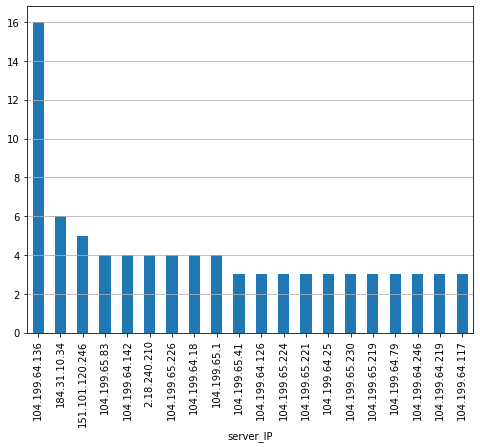

In [32]:
# Point 8.2
# Plot the number of distinct sub-services for each server IP
a = sp_dataf.groupby(['server_IP'])['hostname'].nunique()\
            .sort_values(ascending=False).head(20).plot(kind='bar', figsize=(8,6), ylabel='number of services')
a.grid(axis='y')


The result shown in this figure validates the hypotesis we made analyzing section 2.3. In fact, we can notice that related to IP address 104.199.64.136 there are 16 different Spotify services confirming us that the associated server is extremely important. Probably, since here figure also the other IP addresses in the range 104.199.64.0/24 and 104.199.65.0/24, the server they refer to may host some other services.     
Excecpt for the IPs already discussed there are only 3 other which appear to have more than a single service hosted on them. They are 184.31.10.34, 151.101.120.246 and 2.15.240.210: the first is related to an Akamai webserver located in the US (therefore used by Spotify for advertisement purposes as said previously) hosting 6 different services, the second belongs to the American company Fastly (provides global edge cloud platform processesing and servers) which hosts 5 services while the last one hosting 4 services refers to a server possessed by the Italian IT.Gate S.p.A. (datacenter solutions for hosting servers).

### 2.5

For this task we are asked to plot the total number of connections per each combination of sub-service and server IP.

In order to do so we group the dataframe all at once according to two the two requested parameters: *server_IP* and *hostname*. 

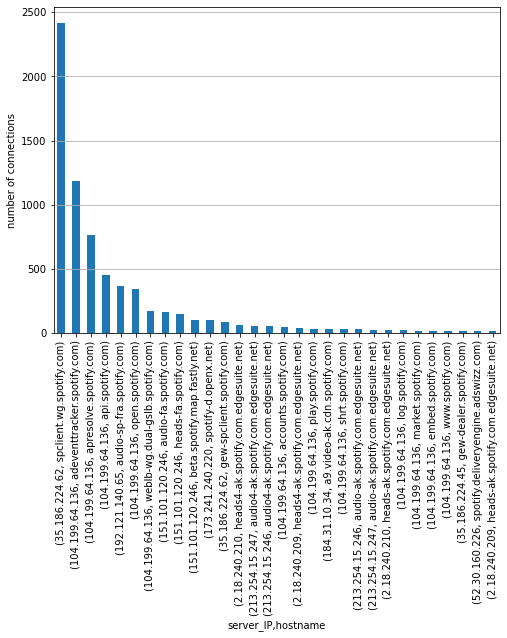

In [4]:
# POINT 9
a = sp_dataf.groupby(['server_IP', 'hostname']).size()\
            .sort_values(ascending=False).head(30).plot(kind='bar', figsize=(8,6), ylabel='number of connections')
a.grid(axis='y')

The combination sub-service - server IP address having the most number of connection is the service *spclient.wg.spotify.com* which is the same having the overall number of connections (section 2.2). The interesting fact is that all those TCP flows are towards the same IP address (35.186.224.62). This is suggesting us that indeed this is an important sub-service for the correct functioning of Spotify and also, given the number of connections, that is hosted in a big server.    
Looking at the x axis labels we can also appreciate the diversity of services that report to the same IP address 104.199.64.136: we have *adventtracker* as well as *paly.spotify*, *api.spotify*, *accounts.spotify* and many others, each one with a specific and diverse task. The same cannot be said of the other matching IPs. In fact if we observe IP 213.254.15.246 we can notice that all its related services are associated to advertisment purposes.

### 2.6

In this section we investigate how many distinct internal network's clients access each server IP address and access each sub-service. 

To accomplish the firs task we need to filter the dataframe according to the internal clients and group the remaining rows by the server IP address, specifying `'client_IP'` to get the client-to-server connection. Then, we plot the result.

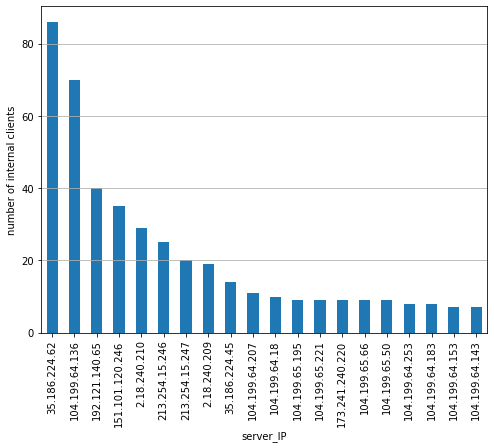

In [6]:
# POINT 10.1
# clients -> local traffic
a = sp_dataf[(sp_dataf['c_isint:38'] == 1)].groupby(['server_IP'])['client_IP']\
            .nunique().sort_values(ascending=False)\
            .head(20).plot(kind='bar', figsize=(8,6), ylabel='number of internal clients')
a.grid(axis='y')

From the graphical result we see that the IP address 35.186.224.62, corresponding to the the service *spclient.wg.spotify.com*, is the most accessed IP address by the internal clients. This is coherent to the analysis done so far: the specified sub-service is indeed the one counting the highest number of connections (as reported in section 2.2 and 2.5). Also the second most accessed IP is expected, since it belongs to the most accessed range of IP addresses and because many different sub-services use it, meaning that each client connecting to Spotify has an high chance of being also connected to that IP address.   

The IP address 192.121.140.65 is associated to a server located in Sweden and the service it provides is audio cache. Because of that it is of course a very often contacted IP. Then, the IPs 2.18.240.209 and 210, 213.254.15.246 and 247 are related to an audio ads service. Also in this case we are not surprised that they figure in the most visited IPs from distinct internal client since it is well known that advertisment has a huge importance to all the online services.    
The IP 151.101.120.246 is instead related to a *beta* Spotify service and we are not sure why it is so much contacted.   
After the 9th position we find mainly IPs related to the direct listening of music (as stated in section 2.4) and they all count an almost equal number of connections. This is possibly due to Spotify will to balance the number of clients' streaming per server IP address, as we have seen that one of the most used sub-services is a load balancer (*ap.gslb.spotify.com*).

Afterwards, we analyze how many distinct clients access each sub-service.

The procedure applied is the same as before but this time we group by *hostname* rather than by server IP.

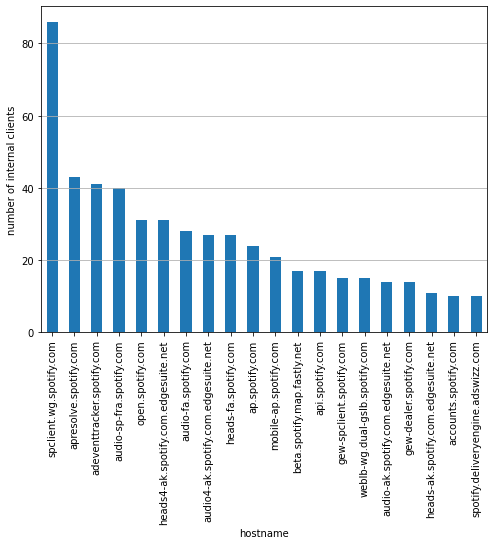

In [7]:
# POINT 10.2
a = sp_dataf[(sp_dataf['c_isint:38'] == 1)].groupby(['hostname'])['client_IP']\
            .nunique().sort_values(ascending=False)\
            .head(20).plot(kind='bar', figsize=(8,6), ylabel='number of internal clients')
a.grid(axis='y')

As expected, we observe an equal number of distinct connections towards the service *spclient.wg.spotify.com* with respect to the previous result since the service corresponding IP address is 35.186.224.62 (which can be observed in the previous graph). This suggests that each internal client in the network willing to contact Spotify opens a distinct connection towards the given service at the specified IP address.   
From the second bar onward the situation is instead much different. In fact, we can observe that we do not have a behavior similar to the previous one, which would have indicated that each client, in order to use any sub-service, opens a connection towards a single server IP but that is not true since we know it from the previously obtained results. This explains why all the sub-service, except the first one, have fewer distinct clients connections with respect to the IPs represented before.    
Observing the figure we can find the two services *ap.spotify.com* and *mobile-ap.spotify.com* only at the 9th and 10th places and some other music-related services further back while we can see instead many advertising and tracking services in the fisrst places.

### 2.7

For this assignment we are asked to count the total number of bytes exchanged from clients to server (uplink direction) and afterwards those exchanged in downlink, i.e. from server to client. In the end we have also to compute which fraction of the clients exchanged with the services more than 1MB in total considering both uplink and downlink.

To do so it is sufficient to sum all the values in the columns `c_bytes_all:9` for the uplink and `s_bytes_all:23` for the downlink.

In [45]:
# POINT 11
# 9 -> c2s ; 23 -> s2c
sp_c2s_bytes = sp_dataf['c_bytes_all:9'].sum()
sp_s2c_bytes = sp_dataf['s_bytes_all:23'].sum()
print(sp_c2s_bytes, "Bytes exchanged from clients to servers.")
print(sp_s2c_bytes, "Bytes exchanged from servers to clients.")

# more than 1MB in total (uplink+downlink)
def count_bytes(row):
    
    if (row['c_bytes_all:9']+row['s_bytes_all:23']) > 1e6:
        return 1
    else:
        return 0

sp_1M_df = 0
sp_1M_df += sp_dataf.apply(count_bytes, axis=1)
sp_1M = (sum(sp_1M_df)/sp_dataf.shape[0])*100
print("Percentage of the clients that exchanged with services more than 1MB in total is {:.2f}%".format(sp_1M))

93569224 Bytes exchanged from clients to servers.
4747563560 Bytes exchanged from servers to clients.
Percentage of the clients that exchanged with services more than 1MB in total is 8.09%


To answer the last question, instead, we decided to create a new method that we called `count_bytes()` which for every flow (row) compliant to the request returns 1 and 0 otherwise. In this, way at the end of the computation, we can just sum all the ones to obtain the total number of connections satisfying the request. Dividing this result by the total number of flows in the dataframe we find that only 8% of the connections exchange more than 1MB of data (uplink + downlink) with the considered services. This indicates that the actual number of flows committed to the streaming of music is really low compared to the whole amount of connections established by Spotify sub-services. We were indeed expacting the presence of many management devoted flows (like checking users account -premium or basic-, communicating the end of the 30 minutes of free listening, triggering the streaming of an advertisement, ect) but the actual result is lower than what we expected it to be.    
In the end we can say that the number of music streams needing a lot of data is absolutely outnumbered and negligible with respect to the number of connections exchanging only very small amount of bytes.

### 2.8

Then, we are asked to evaluate the total number of bytes handled by each server IP address, computing this metric separately for the uplink (client to server) and the downlink (server to client). Afterwards, we have to plot the results in decreasing order, using bar plots. In the end we have to repeat the evaluation considering sub-services instead of servers.

In the following two sections we concetrate on the first part of the assignment, namely the one concerning server IP addresses. The aimed output is therefore obtained by grouping the flows according to their `'server_IP'` and subsequently first by the total number of uplink bytes and secondly by the total number of downlink bytes.

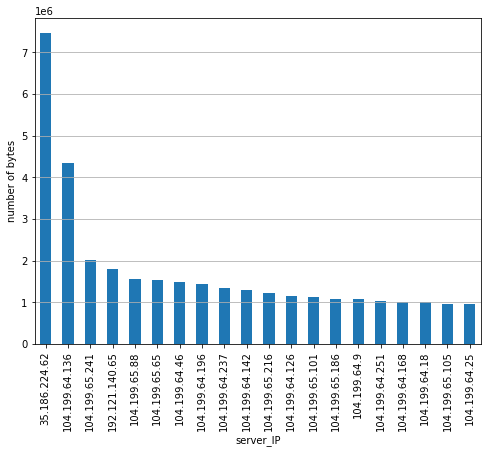

In [13]:
# POINT 12.1.1
a = sp_dataf.groupby(['server_IP'])['c_bytes_all:9'].sum()\
            .sort_values(ascending=False).head(20)\
            .plot(kind='bar', figsize=(8,6), ylabel='number of bytes')
a.grid(axis='y')

The result depicted in the figure confirms once more the results and the comments we have done in our analysis so far: the server IP address 35.186.224.62 is not only the most contacted by clients but is also the one receiving the most number of bytes from them. This support our hypothesis that the service it supports it is of foundamental importance for Spotify and is hosted in some big dedicated server.    
All the other server IP addresses (except one) reported in the figure are instead related to the other big bunch of addresses we suppose is associated to another big server (or set of servers). In fact, we have seen in previous results that those IPs are very numerous and are hosting many sub-services.

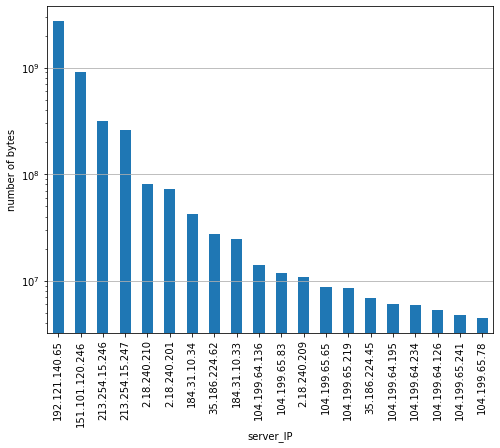

In [15]:
# POINT 12.1.2
fig, ax2 = plt.subplots()

a = sp_dataf.groupby(['server_IP'])['s_bytes_all:23'].sum()\
            .sort_values(ascending=False).head(20)\
            .plot(kind='bar', ax=ax2, logy=True, figsize=(8,6), ylabel='number of bytes')

ax2.grid(axis='y')

The graph shows that the most downlink amount of data is from the server associated to the IP address 192.121.140.65 that, as already mentioned, is associated to a server performing audio cache service (located in Sweden). This is a clear explenation of why this address is the one with the most downlink data traffic and also appears among the IPs in the previous plot (those with the most bytes of data coming from users in uplink).    
We can observe also in this graph the presence of the IP address that in the previous evaluation was the first one as well as a significant number of IPs in the range 104.199.0.0/14.    
Then, in the very first positions there are also some Italy located servers, which should not surprise since are the ones closest to Politecnico's internal clients and is therefore logical to think that they exchange more data with them with respect to servers located in the US. 

We now concentrate on the bytes exchangend between clients and sub-services. The only difference with the previous lines of code relies in the grouping parameter which in the following will be done accordingly to `hostname` column of the dataframe. First we consider the uplink direction and in the following the downlink.

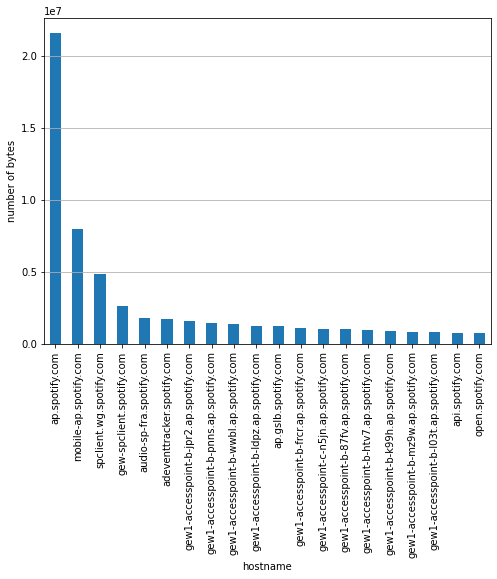

In [21]:
# POINT 12.2.1
a = sp_dataf.groupby(['hostname'])['c_bytes_all:9'].sum()\
            .sort_values(ascending=False).head(20)\
            .plot(kind='bar', figsize=(8,6), ylabel='number of bytes')
a.grid(axis='y')
# print(sp_dataf.groupby(['hostname'])['c_bytes_all:9'].sum()\
#             .sort_values(ascending=False).head(20))

From the above figure we can notice that the first two services having the most bytes of data coming from clients are also the two having the most associated IP addresses as reported in section 2.4. Also this result is indeed coherent with all the previously obtained results since they are two gateway services and it is logical that those are also the ones receiving more data from clients. Actually, also the third one is a client gateway and we can clearly see that the number of bytes for all of them is at least twice larger than the highest among all the others (*gew-spclient.spotify.com* a redirector service).    
Among the others, we can observe a significante presence of "*gew*" domains, which we recall are Europe accesspoints, and the almost absence of services related to advertisement and tracking, except for *adeventtracker* (tracks advertisments triggered and played). The difference between this service and most of the others with the same duty is that this is directly related and owned by Spotify while the others are services that are only used by spotify but mainly owned by other companies (Akamai Internetional, Amazon, etc)

Next, we analyze the downlink instead.

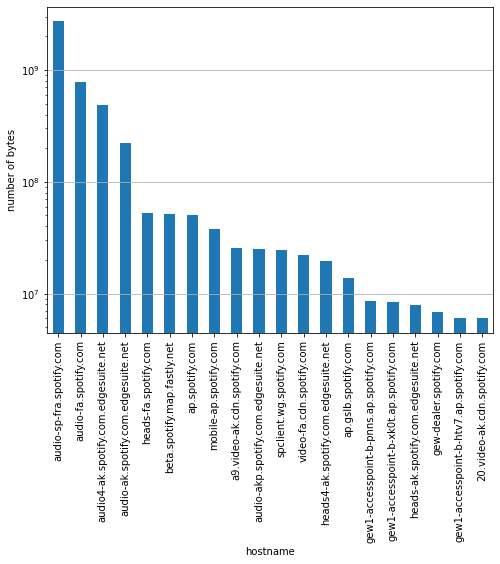

In [18]:
# POINT 12.2.2
fig, ax2 = plt.subplots()

a = sp_dataf.groupby(['hostname'])['s_bytes_all:23'].sum()\
            .sort_values(ascending=False).head(20)\
            .plot(kind='bar', ax=ax2, logy=True, figsize=(8,6), ylabel='number of bytes')

ax2.grid(axis='y')

The first main difference with respect to the previous graph is the heavy presence of many advertisement services, also occupying some of the first positions.     
Anyhow, also in this case we find the two caching services as the first two sending the most data towards clients, as it happened previously when we were investigating the amount bytes sent from each IP address. Since most services
have more than one IP associated to them, in this graph they result having a lot more sent bytes to clients with respect to single IPs. The only one not changing because has a single IP address is the *spclient.wg.spotify.com*. Interestingly, the services we discovered in section 2.4 having the most associated IPs are not in the very first positions in this graph but we can find them only in 7th and 8th places.

### 2.9

For this task we have to extract for each server IP the minimum and the average RTT (among all the minimum and average values) from the client to the server, ordering them accordig to the one handling the most clients (section 2.6)

In order to meet the requirements we have to filter the dataframe according to the internal clients first. Then, we have to group the filtering result by *server_IP* and apply to it the `groupby.DataFrameGroupBy.agg()` method, specifying that we want all the unique clients IPs, the minimum of the minimum RTT and average of the average RTT. Finally, we plot the top-20 results in a bar plot in decreasing order.

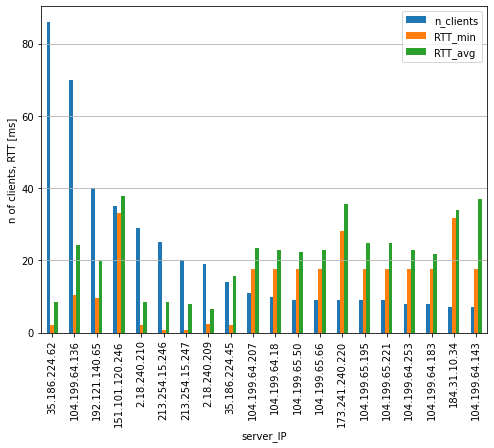

In [6]:
# POINT 13
fig, ax2 = plt.subplots()

a = sp_dataf[(sp_dataf['c_isint:38'] == 1)]\
        .groupby(['server_IP']).agg({'client_IP':'nunique', 'c_rtt_min:46':'min', 'c_rtt_avg:45':'mean'})\
        .sort_values('client_IP', ascending=False)\
        .rename(columns={"client_IP": "n_clients", 'c_rtt_min:46':'RTT_min', 'c_rtt_avg:45':'RTT_avg'})\
        .head(20).plot(kind='bar', ax=ax2, figsize=(8,6), ylabel='n of clients, RTT [ms]')

ax2.grid(axis='y')
# print(sp_dataf[(sp_dataf['c_isint:38'] == 1)]\
#         .groupby(['server_IP']).agg({'client_IP':'nunique', 'c_rtt_min:46':'min', 'c_rtt_avg:45':'mean'})\
#         .sort_values('client_IP', ascending=False).head(20))

In section 2.4 and also in some of the following ones we did a research to try to geolocate most of the sub-services' servers based on their IPs.      
Based on the results reported in the plot we can have a rough estimation of the distance between the clients and the servers. A precise measure of the physical distance between two hosts in a real network is indeed impossible to make. In fact, we cannot know how many switches and routers (which introduce delays) a packet may cross along its path toward its destiation only relying on the RTT measure. Furthermore, the RTT metric strongly depends on the traffic at the moment of the measure. Moreover, we do not know which are the transmission medium packets went through and this is a crucial parameter because the propagation speed of signals depend on the material they have to traverse (optical cable, copper cable, air).     
Theoretically, RTT can be evaluated as 2\*(distance/propagation_speed), therefore we can evaluate a very rough estimation of the distance between clients and servers as (RTT\*propagation_speed)/2 (for simplicity we consider the propagation speed of optical cables - 2/3\*c = \~2e8 m/s - for our evaluations).

Following all the assumptions mentioned, we tried to estimate the distances from clients for all the server IPs illustrated in the figure.      

We first analyze IP addresses 2.18.240.209/210 and 213.254.15.246/247: according to the previous research we conducted they resulted to belong to servers located in Milan. If we look at the graph we can clearly notice that indeed they are the servers with the lowest minumum and average RTT values. By a deeper inspection, considering the minimum RTT only, this geolocalization is compliant: with a minimum RTT of \~2.28 ms and \~0.75 ms respectively, applying the formula shown before we obtain an indicative distance of 228 km and 75 km respectively. Since the distance between Turin and Milan is about 145 km (city center to city center) using the highway, considering that usually optical fiber cables are placed in correspondance of highways, considering also that Milan is a very big city and supposing that those server are not placed in the city center (specifically the first ones in the other side of Milan with respect to Turin and the latter ones before Milan coming from Turin) is plausible that they are indeed placed around Milan and the information we retrieved from internet is correct.     
If we instead consider the average RTTs thigs are really different. Their average RTT is almost the same for the four of them (\~8.5 ms) and as a direct consequence also the resulting distance which is around 850 km. This evaluation is surely wrong (assuming our previous one is correct) but at the same time gives us a good measure of the average status of the network: on average the link between Politecnico and Milan placed servers has so much traffic that the RTT is almost 4 times higher than the best case.    

Then, we concentrate an the other two IPs which from our researches resulted to be placed in Europe: 192.121.140.65 (Stockholm) and 151.101.120.246 (Paris). The first one, corresponding to an audio caching service, has indicative distances obtained from RTTs which are coherent with our geolocalization: considering its minimum value the distance results to be \~947 km while with its average value \~1974 km. In this case we cannot make any assumption on the physical position of the optical fiber cables, but the approximated distance as the crow flies is about 1700 km between Turin and Stockholm. For the second one instead things are not straightfroward. In fact, the rough measurements place the server at 3300 km and 3779 km from the clients respectively for the minimum and average RTTs. A possible explanation for this behavior is that the actual path packets need to travel is much longer than we expect, crossing therefore many switches and routers adding delay and therefore resulting in an approximated distance like the one obtained.      

Finally, we investigate all the other IP addresses. All of them resulted to be located in the US but we can clearly see from the figure that this is indeed impossible. A server located in the US with a direct communication with a client located at Politecnico would have had RTT values not lower than a hundred milleseconds since data has to reach the Atlantic Ocean, travers it, reach its destination (we found Kansas City, Missouri and Mountain View, California) and then an answer should come back. Therefore, we suppose that the connections are not directed directly towards those servers but to some European placed server farm. Doing some more in-depth researches we found out that all the IP addresses Google provides to Google Cloud Platform (GCP) users are registered with ARIN (American Registry for Internet Numbers) under the Google HQ in Mountain View, California. Thus, all geolocations lookup for those addresses will resolve to the United States even though the actual server is located somewhere else.       
Since the servers we analyzed should be Google owned, by looking at the places where Google has its servers in Europe we discovered that many of them are at distances from Turin coherent with the rough distance evauated from the graph. Specifically, from the graph we can notice that all IPs starting with 104 in the right part of the chart have similar RTT values, giving a minimum indicative distance of 1770 km and an average one of 2300 km each. These values are compatible with some of the Google server farms in Europe like the one in Danmark (\~1500 km) or the two in Nederland (\~1300 km both).      
The two IPs not in the 104 range may instead be related to servers located in Dublin where it is well known many tech companies have their servers (Google, Amazon, Fastly, etc), since their RTT values are higher and suitable for such distance.    

Other peculiar cases are represented by the first and last IP addresses in the figure, starting again with 104. The last one has an average RTT compatible with the larger distances like the two addresses just analized, but has a minimum RTT coherent with the considerations done with servers placed in Danmark and Nederland. It is possible that the same IP is managed by different servers during time, maybe in order to balance internal traffic. Thus, it is probable that the minimum value was evaluated while the connection was established with a closer server but this value may have been averaged out by connections covering longer distances. This consideration was indeed confirmed by some research on Google IP addresses.      
The first 104 IP address in the chart instead have a similar behavior with respect to the last one but the minimum distance is compatible with the Swedish server previously analyzed and the average RTT resembles that of the other IPs in its same range.      

In the end, the RTT values for the IP 35.186.224.62 are not consistent with the geolocalization in Kansas City, Missouri, USA. They are instead very similar to those of Milan servers. This makes us belive that there is an identical situation to the one we depicted before for the Google owned servers, but those ones should be located somewhwere near Milan.

### 2.10

We are now asked to make a scatter plot considering a point for each sub-service, which have to be characterized by the number of connections and the number of exchanged bytes.

In order to get to the aimed result we group the dataframe according to sub-services names (*hostname*) and subsequently we compute the number of connections per sub-service and the total number of exchanged bytes. We sort the results in descending order and we plot them in a scatter plot using log scale for both x and y axes.

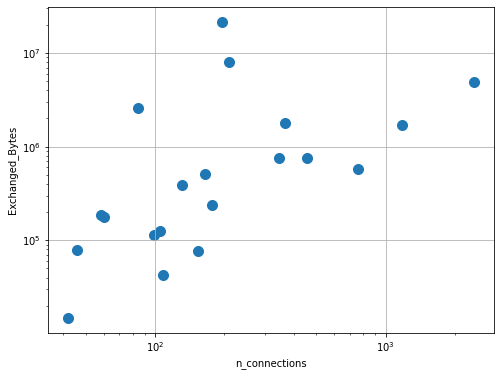

In [7]:
# POINT 14
a = sp_dataf.groupby(['hostname']).agg({'hostname':'size', 'c_bytes_all:9':'sum'})\
        .rename(columns={"hostname": "n_connections", 'c_bytes_all:9':'Exchanged_Bytes'})\
        .sort_values('n_connections', ascending=False).head(20)\
        .plot.scatter(x='n_connections',y='Exchanged_Bytes', s=100, loglog=True, grid=True, figsize=(8,6))


The overall trend shown in the figure is almost linear: the more the number of connections the higher the number of bytes exchanged. There are only few connections that are not consistent with this trend. In fact, we can observe that there are 3 sub-service that have few connections (around 10^2) but a lot of exchanged bytes (tens of MB).     
We can also notice that there are much more sub-services with few connections and few exchanged bytes rather than sub-services with many connections and many exchanged bytes.

The informations we can retrieve from this plot confirm what we already mentioned in section 2.8 and all our previous analysis and considerations.

### 2.11

For this task we have to plot a heatmap representing the number of bytes exchanged between the top-20 most active clients (in terms of number of connections) and the top-20 most contacted sub-services (in terms of number of connections).

In order to fulfill the requirements we have first to generate two grouped versions of the dataframe according to the top-20 clients and sub-services in terms of number of connections, as specified in the task. Then, we create another dataframe filtering according to the groups generated before. Finally, we create the heatmap using the *seaborn* library using *hostname* as indexes and *client_IP* for the columns. 

15. annotate the cells with whole numbers. Comment on the plot.

<AxesSubplot:xlabel='client_IP', ylabel='hostname'>

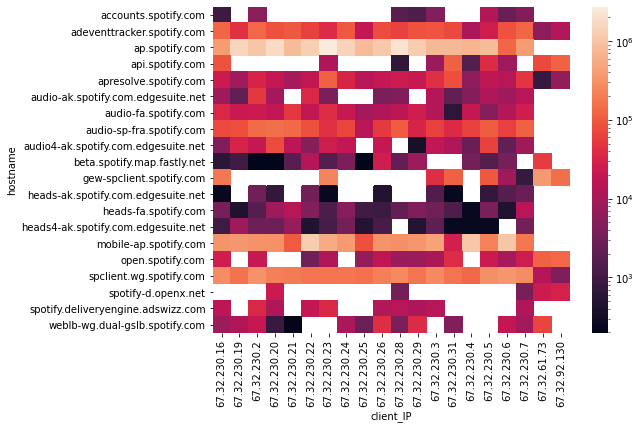

In [10]:
# POINT 15
top_clients = sp_dataf.groupby(['client_IP']).size().sort_values(ascending=False).head(20)
top_services = sp_dataf.groupby(['hostname']).size().sort_values(ascending=False).head(20)

temp = sp_dataf[(sp_dataf['client_IP'].isin(top_clients.keys()) & sp_dataf['hostname'].isin(top_services.keys()))]
table = pd.pivot_table(\
                       temp,\
                       values='c_bytes_all:9', index='hostname', columns='client_IP',\
                       aggfunc=np.sum)
#should be the sum of bytes to client and bytes to server?
plt.figure(figsize=(8,6))
sns.heatmap(table, norm=LogNorm())
# print(temp.groupby(['hostname']).size().sort_values(ascending=False).head(20))

From the heatmap we can notice that the most contacted services are mainly *spotify.deliveryengine.adswizz.com*, *spotify-d.openx.net*, *heads-ak.spotify.com.edgesuite.net*, *gew-spclient.spotify.com*, *api.spotify.com* and *accounts.spotify.com*. As we already mentioned in the analyses done so far, the most contacted services are in general those related to advertisment services and it is indeed true also looking at these results. In fact, the first 3 mentioned services are all advertisement services: AdsWizz is a digital audio advrtising platform, OpenX is a programmatic advertising technology company, Edgesuite.net is run by Akami Technologies which is a content delivery network (this last one should also used for audio streaming). All the other mentioned services are instead directly related to Spotify: *api.spotify* is part of the Spotify public network (default api), *gew-spclient* is a redirector and *accounts.spotify* connects to users account page (it also links to *weblb-wg.dual-gslb.spotify.com* another sub-service with many connections).       
From the figure we can also observe that *ap.spotify*, *mobile-ap.spotify* and *spclient.wg* are the 3 most contacted services immediatly after the ones mentioned before. Also this last consideration confirms and validates all the results already observed in previous sections.

An interesting behavior can be observed for the two rightmost client IPs. They result to have a lot of data exchanged with the majority of the services.

ALTRO?

### 2.12

Next, we are asked to plot a  boxplot of the distribution of the fraction of retransmitted packets from the
client to the server and vice-versa for each sub-service.

Here, for each sub-service in the dataframe, we count the total number of packets exchanged with clients and we evaluate the fraction of retransmissions by dividing the number of retransmitted packets by the total number of packets. Then, we plot the results

16. For , plot a boxplot of the distribution of the fraction of retransmitted packets from the
client to the server and vice-versa. Is there a sub-service with a lot of retransmitted packets? What could be
possible reasons for a large number of retransimissions?

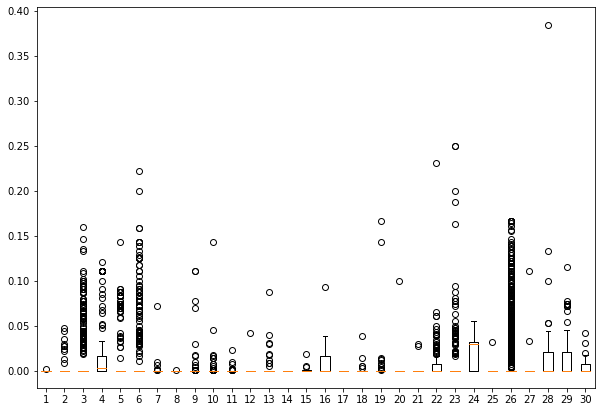

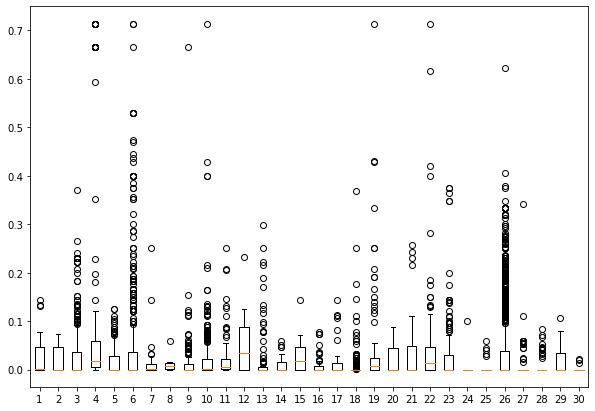

In [24]:
# POINT 16
c_rtx = []
s_rtx = []
names = []
for hostname,data in sp_dataf.groupby(['hostname']):
    # filter out meaningless data
    if len(data)<10:   
        continue
    tot_pkts = data['c_pkts_all:3'] + data['s_pkts_all:17']
    c_rtx.append(data['c_pkts_retx:10']/tot_pkts)
    s_rtx.append(data['s_pkts_retx:24']/tot_pkts)
    names.append(hostname)

plt.subplots(figsize =(10, 7))
p1 = plt.boxplot(c_rtx)

plt.subplots(figsize =(10, 7))
p2 = plt.boxplot(s_rtx)

From the first graph (packets retransmitted by clients) we can appreciate that the majority of sub-services have negligible retransmission rate. In fact, we can notice that there are almost all median lines (yellow lines) aligned with the bottom line (corresponding to 0). This fact indicates that almost all services experices only outliers (empty circles) with respect to the distribution and are therefore negligible. Moreover, the retransmission fraction for those fliers is also very low, attesting itself on average to 1/10 of the total number of packets. Furthermore we can also see that there is only a single sub-service connection experiencing almost 40% of retransmissions, probably due to high network load or long packet to be transmitted. 

The second figure is instead very different (packets retransmitted by servers). Here there are far more retransmissions and many more medians higher than 0. Moreover, with respect to the previous case, we can notice also many more boxes which indicates that there is more dispersion for the data. Furthermore, in this plot we can observe many more outlier values, with higher retransmission fractions as well. Since usually servers have to transmit a lot more data than clients (as seen in section 2.8) it is also logical to observe many more retransmissions: the more it is transmitted, the higher the probability of collisions, of loss and errors. It has also to be considered that the packets sent by servers may also be much larger than those of clients. 

17. Draw the empirical Probability Distribution Function (PDF) and the empirical Cumulative Distribution
Function (CDF) of the RTT (server to client, you can choose between minimum, average or maximum). The
PDF should be estimated either with a histogram or with a proper density estimation. The CDF should be
computed precisely (see lecture slides).

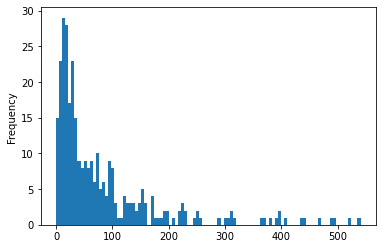

In [25]:
# POINT 17
pdf_df = sp_dataf.groupby(['hostname'])['s_rtt_avg:52'].mean()

# filter out outliers
a = pdf_df[(pdf_df < pdf_df.quantile(0.95))].plot.hist(bins=100)


18. Play with the other columns. Which analysis do you think would be interesting? (I) Propose some analyses, (ii) show its results, (iii) comment on the findings.

In [ ]:
# number of retransmissions per connection vs packet size

In [14]:
list(sp_dataf.columns)

['#15#c_ip:1',
 'c_port:2',
 'c_pkts_all:3',
 'c_rst_cnt:4',
 'c_ack_cnt:5',
 'c_ack_cnt_p:6',
 'c_bytes_uniq:7',
 'c_pkts_data:8',
 'c_bytes_all:9',
 'c_pkts_retx:10',
 'c_bytes_retx:11',
 'c_pkts_ooo:12',
 'c_syn_cnt:13',
 'c_fin_cnt:14',
 's_ip:15',
 's_port:16',
 's_pkts_all:17',
 's_rst_cnt:18',
 's_ack_cnt:19',
 's_ack_cnt_p:20',
 's_bytes_uniq:21',
 's_pkts_data:22',
 's_bytes_all:23',
 's_pkts_retx:24',
 's_bytes_retx:25',
 's_pkts_ooo:26',
 's_syn_cnt:27',
 's_fin_cnt:28',
 'first:29',
 'last:30',
 'durat:31',
 'c_first:32',
 's_first:33',
 'c_last:34',
 's_last:35',
 'c_first_ack:36',
 's_first_ack:37',
 'c_isint:38',
 's_isint:39',
 'c_iscrypto:40',
 's_iscrypto:41',
 'con_t:42',
 'p2p_t:43',
 'http_t:44',
 'c_rtt_avg:45',
 'c_rtt_min:46',
 'c_rtt_max:47',
 'c_rtt_std:48',
 'c_rtt_cnt:49',
 'c_ttl_min:50',
 'c_ttl_max:51',
 's_rtt_avg:52',
 's_rtt_min:53',
 's_rtt_max:54',
 's_rtt_std:55',
 's_rtt_cnt:56',
 's_ttl_min:57',
 's_ttl_max:58',
 'p2p_st:59',
 'ed2k_data:60',
 'ed